In [1]:
import zipfile
import os 
import torch
from torch import nn
from torch.utils.data import Dataset, dataloader
from torchvision.datasets import Flowers102
from torchvision.transforms import v2
from skimage import color
from torch.nn.functional import relu
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device used : {device}")

device used : cuda


In [2]:


local_zip = './DIV2K_train_LR_x8.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('.')
zip_ref.close()

local_zip = './DIV2K_valid_LR_x8.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('.')
zip_ref.close()

train_directory = './DIV2K_train_LR_x8'
test_directory = './DIV2K_valid_LR_x8'

In [3]:
class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.dataset = os.listdir(directory)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = plt.imread(os.path.join(self.directory, self.dataset[idx]))
        if self.transform:
            image = self.transform(image)
        return image[0,...].unsqueeze(0), image[1:,...]

In [4]:
class CustomFlowersDataset(Dataset):
	def __init__(self, root, split="train", transform=None, download=False):
		self.flowers_dataset = Flowers102(root=root, split=split, download=download)
		self.transform = transform

	def __getitem__(self, index):
		image, _ = self.flowers_dataset[index]
		if self.transform is not None:
			image = self.transform(image)
		return image[0,...].unsqueeze(0), image[1:,...]

	def __len__(self):
		return len(self.flowers_dataset)


In [5]:
root_dir = "./ressources"

transform = v2.Compose([
	color.rgb2lab,
	v2.ToImage(),
	v2.ToDtype(torch.float32),
	v2.Resize((128,128), antialias=True),
])

# train_dataset = CustomFlowersDataset(root=root_dir, split="train", transform=transform, download=False)
# test_dataset = CustomFlowersDataset(root=root_dir, split="test", transform=transform, download=False)
train_dataset = ImageDataset(train_directory, transform=transform)
test_dataset = ImageDataset(test_directory, transform=transform)

Train dataset size: 800
Test dataset size: 100
Images shapes :torch.Size([1, 128, 128]) (input), torch.Size([2, 128, 128]) (target)


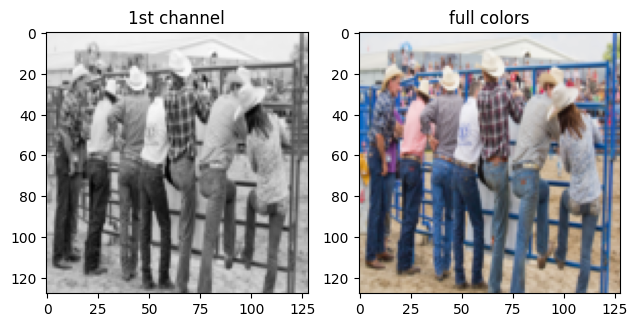

In [6]:
def tensorToImg(tensor:torch.Tensor):
	return tensor.moveaxis(0,2).detach().cpu().numpy()

print("Train dataset size:",len(train_dataset))
print("Test dataset size:",len(test_dataset))
img1, img2 = test_dataset[0]
print(f"Images shapes :{img1.shape} (input), {img2.shape} (target)")
fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2)
ax1.imshow(tensorToImg(img1), cmap="grey")
ax1.set_title("1st channel")
img_colored = torch.cat((img1, img2), dim=0)
ax2.imshow(color.lab2rgb(tensorToImg(img_colored)))
ax2.set_title("full colors")
plt.tight_layout()

In [7]:
class ColorNN(nn.Module):
	def __init__(self, *args, **kwargs) -> None:
		super().__init__(*args, **kwargs)
		self.encoder = nn.Sequential(
			self.DoubleConv2d(1, 64),
			nn.MaxPool2d(2),
			self.DoubleConv2d(64, 128),
			nn.MaxPool2d(2),
			self.DoubleConv2d(128, 256),
			nn.MaxPool2d(2),
			self.DoubleConv2d(256, 512),
		)
		self.decoder = nn.Sequential(
			nn.ConvTranspose2d(512, 256, 2, 2),
			self.DoubleConv2d(256, 256),
			nn.ConvTranspose2d(256, 128, 2, 2),
			self.DoubleConv2d(128, 128),
			nn.ConvTranspose2d(128, 64, 2, 2),
			self.DoubleConv2d(64, 64),
		)
		self.final = nn.Conv2d(64, 2, 1)
	
	def forward(self, X):
		return self.final(self.decoder(self.encoder(X)))
		
	
	def DoubleConv2d(self, c_in, c_out, k_size=3):
		return nn.Sequential(
			nn.Conv2d(c_in, c_out, k_size, padding=1),
			nn.ReLU(),
			nn.Conv2d(c_out, c_out, k_size, padding=1),
			nn.ReLU()
		)

In [8]:

class NetworkColor(nn.Module):
    def __init__(self):
        """
        Initializes each part of the convolutional neural network.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)

        self.t_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.t_conv1_bn = nn.BatchNorm2d(32)
        self.t_conv2 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        """
        Implements the forward pass for the given data `x`.
        :param x: The input data.
        :return: The neural network output.
        """
        x = relu(self.conv1_bn(self.conv1(x)))
        x = relu(self.conv2_bn(self.conv2(x)))

        x = relu(self.t_conv1_bn(self.t_conv1(x)))
        x = relu(self.t_conv2(x))
        return x

In [9]:
# Define the model
model = NetworkColor().to(device)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)





In [10]:
# Dataloaders
train_dataset = [train_dataset[i] for i in range(len(train_dataset))]
train_loader = dataloader.DataLoader(train_dataset, shuffle=True, batch_size=64)
test_loader = dataloader.DataLoader(test_dataset, shuffle=True, batch_size=64)


In [11]:



# Training loop
def train_loop(dataloader, model, loss_fn, optimizer):
	size = len(dataloader.dataset)
	
	model.train()
	
	for batch, (X, y) in enumerate(dataloader):
		# Compute prediction and loss
		X = X.to(device)
		y = y.to(device)
		pred = model(X)
		loss = loss_fn(pred, y)

		# Backpropagation
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if batch % 10 == 0:
			loss, current = loss.item(), (batch + 1) * len(X)
			print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
	return loss.item()


In [12]:
def select_n_random(data, n=3):
    perm = torch.randperm(len(data))
    listData = [data[perm[i]] for i in range(n)]
    return listData

def plot_images_colorization(model, data):
    model.eval()
    
    fig = plt.figure()
    axes = fig.subplots(len(data), 3)
    for i, (ax1, ax2, ax3) in enumerate(axes):
        img1, img2 = data[i]
        img1 = img1.unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(img1)
        img1 = img1[0]
        out = torch.cat((img1, out[0]), dim=0).to(device)
        img1 = img1.cpu()
        ax1.imshow(img1.moveaxis(0, 2), cmap="grey")
        ax2.imshow(color.lab2rgb(out.detach().moveaxis(0, 2).cpu()))
        img2 = torch.cat((img1, img2), dim=0)
        ax3.imshow(color.lab2rgb(img2.moveaxis(0, 2).cpu()))
        ax1.axis("off")
        ax2.axis("off")
        ax3.axis("off")
    return fig

In [16]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Set the number of epochs
num_epochs = 1000

train_acc = []
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_loader, model, criterion, optimizer)
    writer.add_scalar("Loss/train", loss, t)
    if (t+1) % 10 == 0:
        data = select_n_random(train_dataset, n=4)
        writer.add_figure('grey/colorized/real',
                            plot_images_colorization(model,data),
                            global_step=t+1)
        writer.flush()
        

print("Done!")
writer.close()

torch.save(model.state_dict(), "./model.pth")

Epoch 1
-------------------------------
loss: 224.514374  [   64/  800]
loss: 195.417816  [  704/  800]
Epoch 2
-------------------------------
loss: 201.117767  [   64/  800]
loss: 182.536285  [  704/  800]
Epoch 3
-------------------------------
loss: 190.248352  [   64/  800]
loss: 228.691010  [  704/  800]
Epoch 4
-------------------------------
loss: 211.934525  [   64/  800]
loss: 188.033752  [  704/  800]
Epoch 5
-------------------------------
loss: 226.116852  [   64/  800]
loss: 195.249878  [  704/  800]
Epoch 6
-------------------------------
loss: 204.506744  [   64/  800]
loss: 213.909119  [  704/  800]
Epoch 7
-------------------------------
loss: 213.982971  [   64/  800]
loss: 236.266098  [  704/  800]
Epoch 8
-------------------------------
loss: 180.415634  [   64/  800]
loss: 210.937805  [  704/  800]
Epoch 9
-------------------------------
loss: 192.706528  [   64/  800]
loss: 273.164459  [  704/  800]
Epoch 10
-------------------------------
loss: 207.423813  [   6

/tmp/ipykernel_5155/3282684642.py:20: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  ax2.imshow(color.lab2rgb(out.detach().moveaxis(0, 2).cpu()))


Epoch 591
-------------------------------
loss: 172.588272  [   64/  800]
loss: 174.608521  [  704/  800]
Epoch 592
-------------------------------
loss: 218.315292  [   64/  800]
loss: 212.846436  [  704/  800]
Epoch 593
-------------------------------
loss: 236.527725  [   64/  800]
loss: 229.989456  [  704/  800]
Epoch 594
-------------------------------
loss: 252.516388  [   64/  800]
loss: 186.198288  [  704/  800]
Epoch 595
-------------------------------
loss: 217.317871  [   64/  800]
loss: 244.587402  [  704/  800]
Epoch 596
-------------------------------
loss: 218.253601  [   64/  800]
loss: 215.914032  [  704/  800]
Epoch 597
-------------------------------
loss: 180.787704  [   64/  800]
loss: 176.503311  [  704/  800]
Epoch 598
-------------------------------
loss: 223.772827  [   64/  800]
loss: 195.706223  [  704/  800]
Epoch 599
-------------------------------
loss: 249.323181  [   64/  800]
loss: 197.766144  [  704/  800]
Epoch 600
-------------------------------
loss

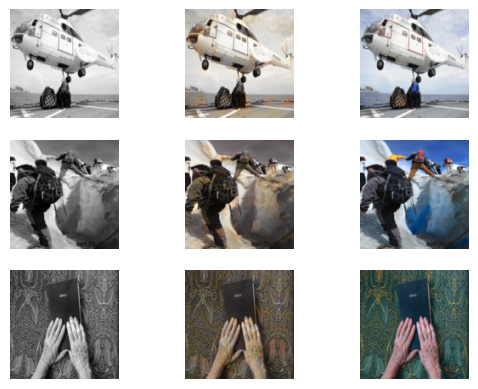

In [14]:
data = select_n_random(train_dataset, n=3)

fig = plot_images_colorization(model, data)


In [15]:
import numpy as np
model = NetworkColor()
model.load_state_dict(torch.load('./model.pth'))
model.to(device)
model.eval()
def colorize_image(input_image, output_image):
    colorized_image = torch.cat((input_image, output_image[0]), dim=0)
    colorized_image = colorized_image.detach().moveaxis(0, 2).cpu()
    colorized_image_rgb = color.lab2rgb(colorized_image)
    return (colorized_image_rgb * 255).astype(np.uint8)


img1, img2 = data[0]
img1 = img1.unsqueeze(0).to(device)
with torch.no_grad():
    output = model(img1)

img1 = img1[0]

colorize_image(img1.to(device), output.to(device))
plt.show()